# Scikit-allel
As this is an evolutionary genetics course, one of the tools we want to put into your toolbox is a way of analysing population scale data (i.e. population genetics data). We already covered in the last lecture how biopython can be used to interface with phylogenetics programs for creating trees or doing maximum likelihood estimation. Today we will take a look at `scikit-allel` which enables easy, python based analyses of common population genetic data formats such as `.vcf` files. 

### Installation
As always our first point of business is installing scikit-allel on everyone's machine. Again we will use conda for this, either at the command line or that Anaconda prompt depending on your setup. 

`conda install -c conda-forge scikit-allel`

`conda install seaborn`

For people on a Windows machine this may cause issues. If so try to install using `pip` at the Anaconda prompt

`pip install scikit-allel`

Hopefully that will get everything we need installed. If not please let me know.



## Setup

Let's import the libraries we'll be using.

In [103]:
import numpy as np
import scipy
import pandas
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import allel; print('scikit-allel', allel.__version__)

scikit-allel 1.2.0


The data we'll be analyzing came from the [Anophele gambiae 1000 genomes project](https://www.malariagen.net/projects/ag1000g). This project is actually the reason that scikit-allel was developed, but it's useful for much much more.  

We will be using data that comes in the form of an HDF5 file containing variant calls from the Ag1000G project phase 1 AR3 data release. These data have been vetted and cleaned up quite a bit before they have gotten to this point. If you have your own sequencing data, think hard about data quality before you get this far. For this example we are going to focus on a 1Mb section of chromosome 3R (28000000-29000000). 

You will download the data for this lesson from this [link](http://sesame.uoregon.edu/~adkern/bi610/ag1000g.phase1.ar3.pass.biallelic.3R.vcf.28000000-29000000.h5). Once you have please put it in your notebooks directory. You can then open the data with the following call

In [40]:
callset_fn = 'ag1000g.phase1.ar3.pass.biallelic.3R.vcf.28000000-29000000.h5'
callset = h5py.File(callset_fn, mode='r')
callset

<HDF5 file "ag1000g.phase1.ar3.pass.biallelic.3R.vcf.28000000-29000000.h5" (mode r)>

## Visualize variant density

As a first step into getting to know these data, let's make a plot of variant density, which will simply show us how many SNPs there are and how they are distributed along the chromosome.

The data on SNP positions and various other attributes of the SNPs are stored in the HDF5 file. Each of these can be treated as a column in a table, so let's set up a table with some of the columns we'll need for this and subsequent analyses.


In [43]:
variants = allel.VariantChunkedTable(callset['variants'], 
                                     names=['POS', 'REF', 'ALT', 'DP', 'MQ', 'QD'],
                                     index='POS')
variants

<VariantChunkedTable shape=(187188,) dtype=[('POS', '<i4'), ('REF', 'O'), ('ALT', 'O', (3,)), ('DP', '<i4'), ('MQ', '<f4'), ('QD', '<f4')]
   nbytes=8.6M cbytes=2.8M cratio=3.1
   values=h5py._hl.group.Group>

The caption for this table tells us that we have 187,187 SNPs (rows) in this dataset.

Now let's extract the variant positions and load into a numpy array.


In [44]:
pos = variants['POS'][:]
pos

array([28000010, 28000013, 28000014, ..., 28999997, 28999998, 28999999],
      dtype=int32)

Define a function to plot variant density in windows over the chromosome.

In [46]:
def plot_windowed_variant_density(pos, window_size, title=None):
    
    # setup windows 
    bins = np.arange(pos.min(), pos.max(), window_size)
    
    # use window midpoints as x coordinate
    x = (bins[1:] + bins[:-1])/2
    
    # compute variant density in each window
    h, _ = np.histogram(pos, bins=bins)
    y = h / window_size
    
    # plot
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.despine(ax=ax, offset=10)
    ax.plot(x, y)
    ax.set_xlabel('Chromosome position (bp)')
    ax.set_ylabel('Variant density (bp$^{-1}$)')
    if title:
        ax.set_title(title)
        

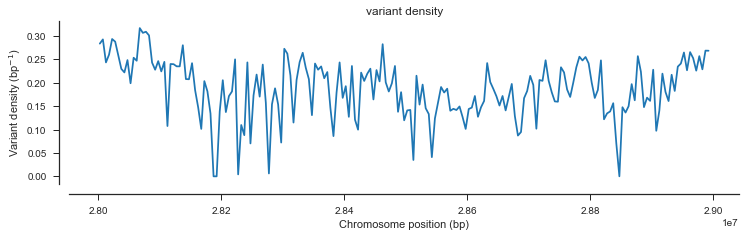

In [47]:
plot_windowed_variant_density(pos, window_size=5000, title='variant density')

from this we can see that the density of SNPs is extremely high in our sample, roughly 0.2 on average which means we should find a SNP every 5 bases. For comparison human populations have 1 SNP every 700 bases on average. 

## Explore variant attributes

As I mentioned above, each SNP also has a number "annotations", which are data attributes that originally came from the "INFO" field in the VCF file. These are important for data quality, so let's begin by getting to know a bit more about the numerical range and distribution of some of these attributes.

Each attribute can be loaded from the table we setup earlier into a numpy array. E.g., load the "DP" field into an array.

In [48]:
dp = variants['DP'][:]
dp

array([24707, 24316, 24322, ..., 24013, 23851, 23997], dtype=int32)

Define a function to plot a frequency distribution for any variant attribute.

In [51]:
def plot_variant_hist(f, bins=30):
    x = variants[f][:]
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.despine(ax=ax, offset=10)
    ax.hist(x, bins=bins)
    ax.set_xlabel(f)
    ax.set_ylabel('No. variants')
    ax.set_title('Variant %s distribution' % f)


"DP" is total depth of coverage across all samples.

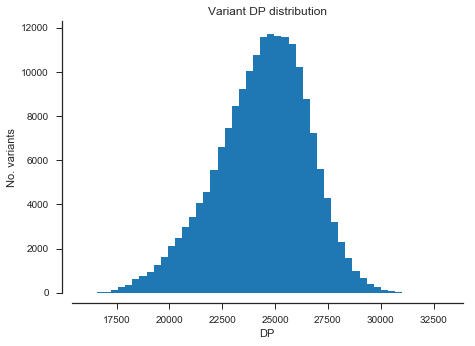

In [52]:
plot_variant_hist('DP', bins=50)

"MQ" is average mapping quality across all samples.

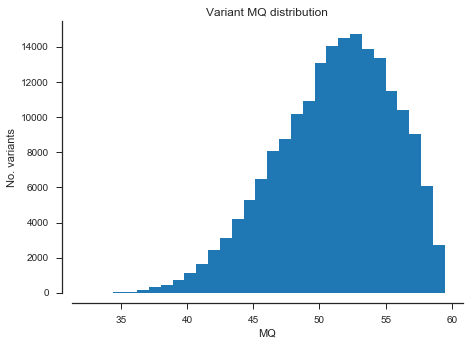

In [53]:
plot_variant_hist('MQ')

The Quality by Depth or "QD" score is a statistic which is quite useful for finding poor quality SNPs. This statistic essentially normalizes quality scores by coverage. We will use it for filtering later.

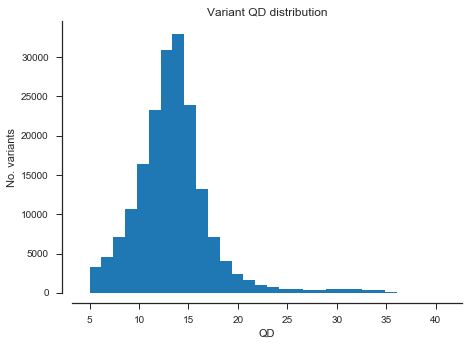

In [55]:
plot_variant_hist('QD')

## Filtering variants

There are many possible approaches to filtering variants. The simplest approach is define thresholds on variant attributes like DP, MQ and QD, and exclude SNPs that fall outside of a defined range (a.k.a. "hard filtering"). This is crude but simple to implement and in many cases may suffice, at least for an initial exploration of the data. 

Let's implement a simple hard filter. First, a reminder that we have a table containing all these variant attributes.

In [56]:
variants

<VariantChunkedTable shape=(187188,) dtype=[('POS', '<i4'), ('REF', 'O'), ('ALT', 'O', (3,)), ('DP', '<i4'), ('MQ', '<f4'), ('QD', '<f4')]
   nbytes=8.6M cbytes=2.8M cratio=3.1
   values=h5py._hl.group.Group>

Define the hard filter using an expression. This is just a string of Python code, which we will evaluate in a moment.

In [62]:
filter_expression = '(QD > 5) & (MQ > 45) & (DP > 15000) & (DP < 30000)'

now evaluate this condition over the entire variant table

In [67]:
variant_selection = variants.eval(filter_expression)[:]
variant_selection

array([ True,  True,  True, ...,  True,  True,  True])

In [68]:
np.count_nonzero(variant_selection)

168384

*neat trick-* How many variants do we filter out?

In [69]:
np.count_nonzero(~variant_selection)

18804

## Subset genotypes

Now that we have some idea of variant quality, let's look at our samples and at the genotype calls.

All data relating to the genotype calls is stored in the HDF5.

In [118]:
calldata = callset['calldata']

genotypes = allel.GenotypeChunkedArray(calldata['GT'])
genotypes

<GenotypeChunkedArray shape=(187188, 765, 2) dtype=int8 chunks=(65536, 64, 2)
   nbytes=273.1M cbytes=9.7M cratio=28.0
   compression=gzip compression_opts=1
   values=h5py._hl.dataset.Dataset>

In [123]:
samples_fn = 'samples.meta.txt'
samples = pandas.read_csv(samples_fn, sep='\t')
samples.head()

,index,ox_code,src_code,sra_sample_accession,population,country,region,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,latitude,longitude
0,0,AB0085-C,BF2-4,ERS223996,BFS,Burkina Faso,Pala,Austin Burt,Sam O'Loughlin,2012,S,F,89905852,28.01,11.150,-4.235
1,1,AB0087-C,BF3-3,ERS224013,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,116706234,36.76,11.233,-4.472
2,2,AB0088-C,BF3-5,ERS223991,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,112090460,23.30,11.233,-4.472
3,3,AB0089-C,BF3-8,ERS224031,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,145350454,41.36,11.233,-4.472
4,4,AB0090-C,BF3-10,ERS223936,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,105012254,34.64,11.233,-4.472


The "population" column defines which of 9 populations the mosquitoes came from, based on sampling location and species. E.g., "BFM" means Anopheles coluzzii mosquitoes from Burkina Faso, "GAS" means Anopheles gambiae mosquitoes from Gabon. How many mosquitoes come from each of these populations?

In [124]:
samples.population.value_counts()

CMS    275
UGS    103
BFS     81
BFM     69
AOM     60
GAS     56
GWA     46
KES     44
GNS     31
Name: population, dtype: int64

Let's work with two populations only for simplicity. These are *Anopheles coluzzii* populations from Burkina Faso (BFM) and Angola (AOM).

In [125]:
sample_selection = samples.population.isin({'BFM', 'AOM'}).values
sample_selection[:5]

array([False,  True,  True,  True,  True])

Now restrict the samples table to only these two populations.

In [126]:
samples_subset = samples[sample_selection]
samples_subset.reset_index(drop=True, inplace=True)
samples_subset.head()

,index,ox_code,src_code,sra_sample_accession,population,country,region,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,latitude,longitude
0,1,AB0087-C,BF3-3,ERS224013,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,116706234,36.76,11.233,-4.472
1,2,AB0088-C,BF3-5,ERS223991,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,112090460,23.30,11.233,-4.472
2,3,AB0089-C,BF3-8,ERS224031,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,145350454,41.36,11.233,-4.472
3,4,AB0090-C,BF3-10,ERS223936,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,105012254,34.64,11.233,-4.472
4,5,AB0091-C,BF3-12,ERS224065,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,98833426,29.97,11.233,-4.472


In [127]:
samples_subset.population.value_counts()

BFM    69
AOM    60
Name: population, dtype: int64

## Subset genotypes by samples & quality
Now let's subset the genotype calls to keep only variants that pass our quality filters and only samples in our two populations of interest.

In [128]:
%%time
genotypes_subset = genotypes.subset(variant_selection, sample_selection)

CPU times: user 1.11 s, sys: 361 ms, total: 1.47 s
Wall time: 1.63 s


In [129]:
genotypes_subset

<GenotypeChunkedArray shape=(168384, 129, 2) dtype=int8 chunks=(2631, 129, 2)
   nbytes=41.4M cbytes=2.1M cratio=19.9
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

The new genotype array we've made has 168,383 SNPs and 129 samples, as expected.

## Allele count
Scikit-allel uses as a first step for population genetic analyses a function called `count_alleles()` that creates an allele count object. The allele_count for each SNP is simply counting how many copies of the reference allele (0) and each of the alternate alleles (1, 2, 3) are observed.

We will use a fancy version of the `count_alleles()` function, `count_alleles_subpops()` that will take a dictionary of population names as part of the input to produce population specific allele counts.  To set this up, define a dictionary mapping population names onto the indices of samples within them.

In [133]:
subpops = {
    'all': list(range(len(samples_subset))),
    'BFM': samples_subset[samples_subset.population == 'BFM'].index.tolist(),
    'AOM': samples_subset[samples_subset.population == 'AOM'].index.tolist(),
}
subpops['AOM'][:5]

[69, 70, 71, 72, 73]

Now perform the allele count.

In [136]:
ac_subpops = genotypes_subset.count_alleles_subpops(subpops, max_allele=3)
ac_subpops

<AlleleCountsChunkedTable shape=(168384,) dtype=[('AOM', '<i4', (4,)), ('BFM', '<i4', (4,)), ('all', '<i4', (4,))]
   nbytes=7.7M cbytes=875.7K cratio=9.0
   values=allel.chunked.storage_zarr.ZarrTable>

Each column in the table above has allele counts for a population, where "all" means the union of both populations. We can pull out a single column, e.g.:

## Locate segregating variants

There are lots of SNPs which do not segregate in either of these populations are so are not interesting for any analysis of these populations. We might as well get rid of them.

How many segregating SNPs are there in each population?


In [141]:
for pop in 'all', 'BFM', 'AOM':
    print(pop, ac_subpops[pop].count_segregating())

all 68585
BFM 58532
AOM 25888


Locate SNPs that are segregating in the union of our two selected populations.

In [142]:
is_seg = ac_subpops['all'].is_segregating()[:]
is_seg

array([False, False, False, ..., False, False, False])

Subset genotypes again to keep only the segregating SNPs.

In [143]:
genotypes_seg = genotypes_subset.compress(is_seg, axis=0)
genotypes_seg

<GenotypeChunkedArray shape=(68585, 129, 2) dtype=int8 chunks=(2144, 129, 2)
   nbytes=16.9M cbytes=2.0M cratio=8.6
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

Subset the allele counts.

In [146]:
ac_seg = ac_subpops.compress(is_seg)
ac_seg

<AlleleCountsChunkedTable shape=(68585,) dtype=[('AOM', '<i4', (4,)), ('BFM', '<i4', (4,)), ('all', '<i4', (4,))]
   nbytes=3.1M cbytes=552.4K cratio=5.8
   values=allel.chunked.storage_zarr.ZarrTable>

# Calculating heterozygosity across the samples
Scikit-allel excels in the ability to calculate population genetic summary statistics across the genome easily and relatively quickly. Let's start by computing the classic estimator of the neutral mutation rate, $\widehat{\theta}_{W} = 4Nu$


In [194]:
pos_sub=np.array(variants['POS'])[variant_selection]
pos_sub_seg = pos_sub[is_seg]
print(pos_sub.shape)
print(pos_sub_seg.shape)

(168384,)
(68585,)


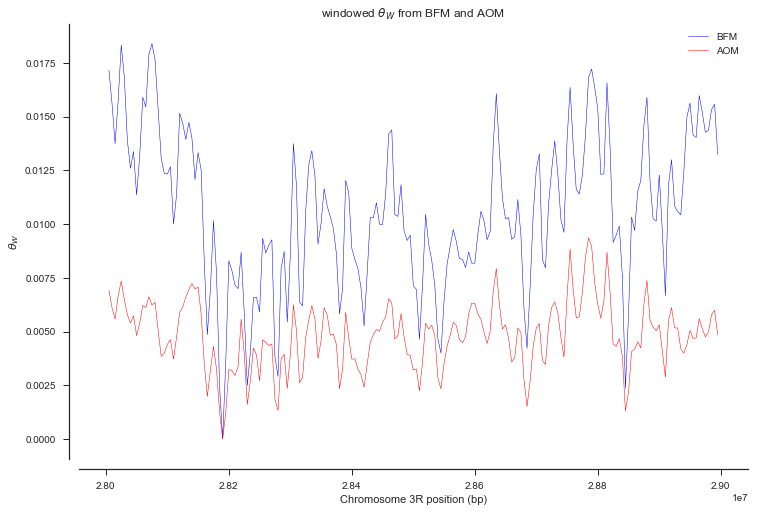

In [244]:
chrom = "3R"
blen = 10000
fig, ax = plt.subplots(figsize=(12, 8))
sns.despine(ax=ax, offset=10)
theta_hat_w_bfm, windows, n_bases, counts = allel.windowed_watterson_theta(pos_sub_seg,ac_seg['BFM'],      
                                size=blen,step=blen // 2)
theta_hat_w_aom, windows, n_bases, counts = allel.windowed_watterson_theta(pos_sub_seg,ac_seg['AOM'],                                                                     
                                size=blen,step=blen // 2)

mids = (windows[:,1] + windows[:,0]) / 2
ax.plot(mids,theta_hat_w_bfm, 'k-', lw=.5, color="blue",label="BFM")
ax.plot(mids,theta_hat_w_aom, 'k-', lw=.5, color="red",label="AOM")

ax.set_ylabel(r'$\theta_{W}$')
ax.set_xlabel('Chromosome %s position (bp)' % chrom)
ax.set_title('windowed 'r'$\theta_{W}$ from BFM and AOM')
ax.legend()
plt.show()


let's quickly calculate the averages. it looks like BFM has higher levels of polymorphism 

In [255]:
import scipy as sp
print('mean theta BFM: ',np.mean(theta_hat_w_bfm))
print('mean theta AOM: ',np.mean(theta_hat_w_aom))
#let's do a test
sp.stats.wilcoxon(theta_hat_w_bfm,theta_hat_w_aom)

mean theta BFM:  0.010623436735403046
mean theta AOM:  0.0048261202798795845


WilcoxonResult(statistic=0.0, pvalue=3.0553725471374046e-34)

so it looks like AOM is indeed much less polymorphic than BFM

## Population differentiation

Are these two populations genetically different? To get a first impression, let's plot the alternate allele counts from each population.

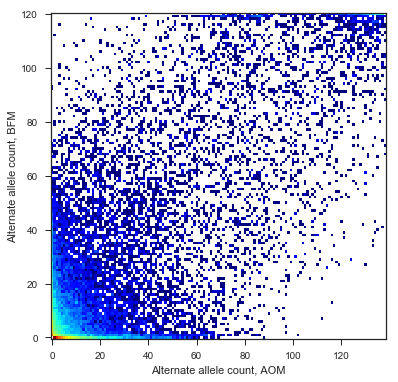

In [156]:
jsfs = allel.joint_sfs(ac_seg['BFM'][:, 1], ac_seg['AOM'][:, 1])
fig, ax = plt.subplots(figsize=(6, 6))
allel.plot_joint_sfs(jsfs, ax=ax)
ax.set_ylabel('Alternate allele count, BFM')
ax.set_xlabel('Alternate allele count, AOM');

Next let's compute Fst between populations across the region

In [151]:
fst, fst_se, _, _ = allel.blockwise_hudson_fst(ac_seg['BFM'], ac_seg['AOM'], blen=1000)
print("Hudson's Fst: %.3f +/- %.3f" % (fst, fst_se))

Hudson's Fst: 0.143 +/- 0.005


this is a reasonably high level of differentiation. The next thing we might be interested in doing is looking at how Fst varies across the chromosome. In particular empiricists are often interested in characterizing outlier regions of differentiation as they might be enriched for candidates for local adaptation

Text(0.5, 0, 'Chromosome 3R position (bp)')

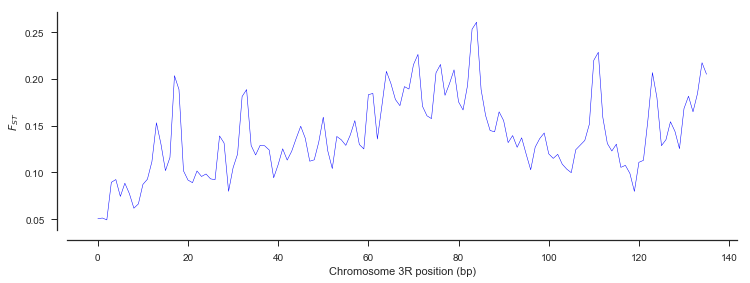

In [170]:
blen = 1000
fig, ax = plt.subplots(figsize=(12, 4))
sns.despine(ax=ax, offset=10)
x = allel.moving_statistic(pos, statistic=lambda v: (v[0] + v[-1]) / 2, size=blen)
y=allel.moving_hudson_fst(ac_seg['BFM'], ac_seg['AOM'],size=blen,step=blen//2)
ax.plot(y, 'k-', lw=.5, color="blue")
ax.set_ylabel('$F_{ST}$')
ax.set_xlabel('Chromosome %s position (bp)' % chrom)
